# Clustering 


### 1. Shape-based clustering 
In the tslearn package are available different clustering methods for time series, such as k-means. 

Following the same structure of the tabular case, we should select the best k by exploiting the elbow method. 


In [28]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# X = random_walks(n_ts=60, sz=40)

In [36]:
from pyts.datasets import make_cylinder_bell_funnel

X, y = make_cylinder_bell_funnel(n_samples=60, random_state=42)
X = X.reshape(X.shape[0], X.shape[1], 1)
X.shape

(60, 128, 1)

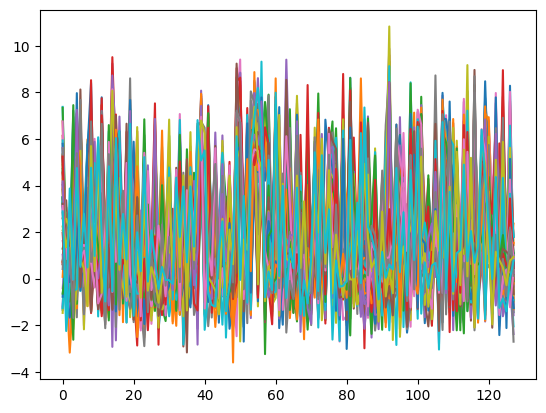

In [37]:
plt.plot(X.reshape(X.shape[1], X.shape[0]))
plt.show()

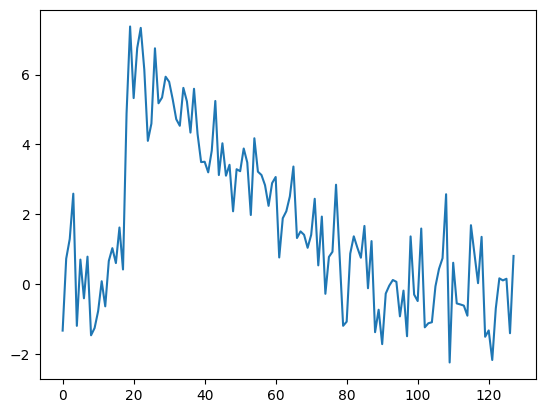

In [65]:
plt.plot(X[0])
plt.show()

Apply the k-means to the time series just generated. 

In [58]:
k = 3
km = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=10, random_state=0)
km.fit(X)

TimeSeriesKMeans(max_iter=10, random_state=0)

Plot the cluster centers to see if there are differences among the different centroids.

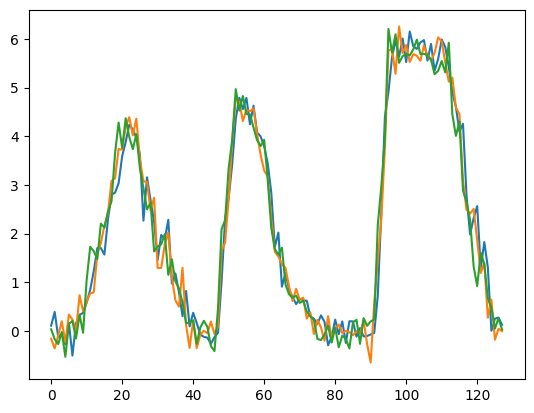

In [59]:
plt.plot(km.cluster_centers_.reshape(X.shape[1], k))
plt.show()

We can change the metric to see if we can separate better the clusters

In [69]:
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

TimeSeriesKMeans(max_iter=5, metric='dtw', random_state=0)

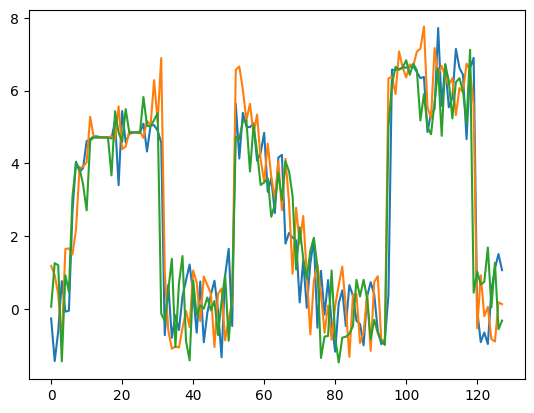

In [70]:
plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], k))
plt.show()

In [71]:
km.inertia_

386.19149180130734

In [72]:
km_dtw.inertia_

64.17748017443292

### 2. Feature-based clustering 
We can apply the clustering to the features extracted. In this case the clustering tecnique applied is the tabular one. 

In [73]:
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [74]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [77]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(F)

KMeans(n_clusters=3, n_init=10)

/Users/lorenzomannocci/anaconda3/envs/phd/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lorenzomannocci/anaconda3/envs/phd/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


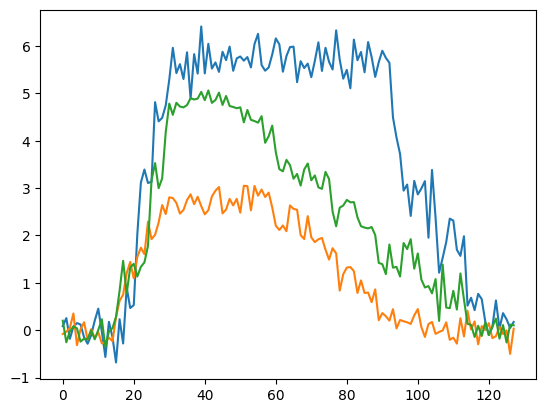

In [78]:
for i in range(k):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

In [79]:
kmeans.inertia_

330.51921979762017

### 3. Compression-based clustering 


In [80]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [81]:
from sklearn.metrics import pairwise_distances
import zlib
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

In [82]:
M

array([[0.51455133, 1.00361736, 1.00405844, ..., 0.99959547, 1.00444086,
        1.00282372],
       [1.00361736, 0.51478817, 1.00242131, ..., 1.00040225, 1.00361301,
        1.00601685],
       [1.00405844, 1.00242131, 0.51466993, ..., 1.00121852, 1.00121605,
        1.00607533],
       ...,
       [0.99959547, 1.00040225, 1.00121852, ..., 0.51417004, 1.00686869,
        1.00363343],
       [1.00444086, 1.00361301, 1.00121605, ..., 1.00686869, 0.51370968,
        1.00483481],
       [1.00282372, 1.00601685, 1.00607533, ..., 1.00363343, 1.00483481,
        0.51449275]])

In [83]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.965, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(eps=0.965, metric='precomputed')

In [84]:
from tslearn.piecewise import PiecewiseAggregateApproximation
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)

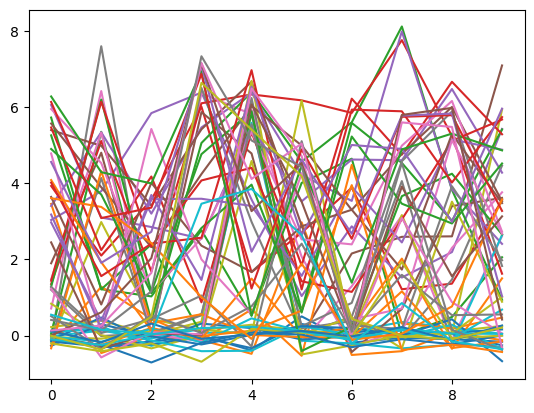

In [85]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [86]:
km = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_paa)

TimeSeriesKMeans(max_iter=5, random_state=0)

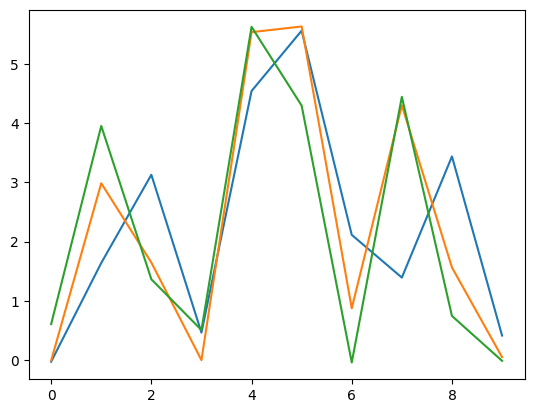

In [87]:
plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 3))
plt.show()

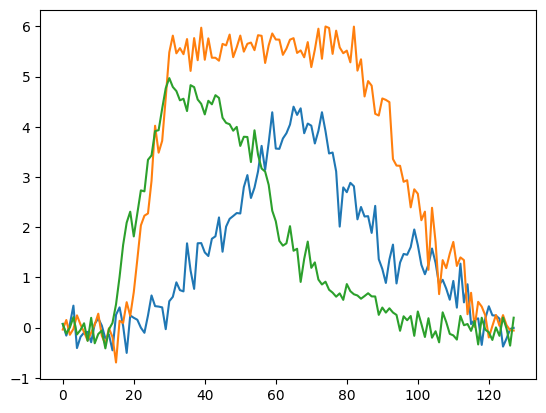

In [90]:
import numpy as np
for i in range(3):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()